In [549]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
from datetime import datetime


# Time series

We will be using the historic performance of the S&P500

In [550]:
data = yf.download("^GSPC", repair=True, multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [551]:
data.head()

,Adj Close,Close,High,Low,Open,Repaired?,Volume
Date,,,,,,,
1927-12-30 00:00:00+00:00,17.660000,17.660000,17.660000,17.660000,17.660000,False,0
1928-01-03 00:00:00+00:00,17.760000,17.760000,17.760000,17.760000,17.760000,False,0
1928-01-04 00:00:00+00:00,17.719999,17.719999,17.719999,17.719999,17.719999,False,0
1928-01-05 00:00:00+00:00,17.549999,17.549999,17.549999,17.549999,17.549999,False,0
1928-01-06 00:00:00+00:00,17.660000,17.660000,17.660000,17.660000,17.660000,False,0


In [552]:
data.index

DatetimeIndex(['1927-12-30 00:00:00+00:00', '1928-01-03 00:00:00+00:00',
               '1928-01-04 00:00:00+00:00', '1928-01-05 00:00:00+00:00',
               '1928-01-06 00:00:00+00:00', '1928-01-09 00:00:00+00:00',
               '1928-01-10 00:00:00+00:00', '1928-01-11 00:00:00+00:00',
               '1928-01-12 00:00:00+00:00', '1928-01-13 00:00:00+00:00',
               ...
               '2024-10-14 00:00:00+00:00', '2024-10-15 00:00:00+00:00',
               '2024-10-16 00:00:00+00:00', '2024-10-17 00:00:00+00:00',
               '2024-10-18 00:00:00+00:00', '2024-10-21 00:00:00+00:00',
               '2024-10-22 00:00:00+00:00', '2024-10-23 00:00:00+00:00',
               '2024-10-24 00:00:00+00:00', '2024-10-25 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=24322, freq=None)

<Axes: xlabel='Date', ylabel='Adj Close'>

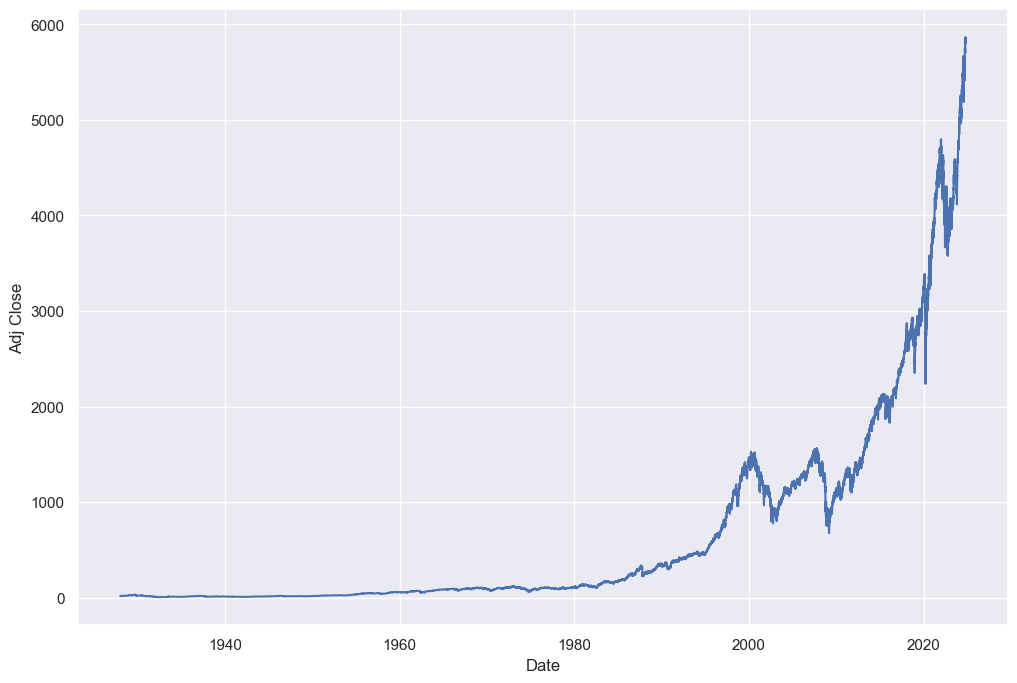

In [553]:
sns.lineplot(data["Adj Close"])

---

# Log returns

Unlike percentage returns, log returns consider compounded returns and can be added together (a property of indicies). This makes them **very** easy to work with

$$
\ln(\cfrac{P_t}{P_{t-1}})
$$


The shift method allows us to move the data down by $x$ rows. A negative value will move the data up.

In [554]:
data["log_returns"] = np.log( (data["Adj Close"] / data["Adj Close"].shift(1)))

Converting into simple return

In [555]:
np.exp(data["log_returns"].sum()) - 1

np.float64(327.8856266914782)

Simple return

In [556]:
(data["Adj Close"].iloc[-1] / data["Adj Close"].iloc[0]) - 1

np.float64(327.88562669147586)

---

# Re sampling

Time series data can be re-sampled into different frequencies such as daily -> monthly. Pandas even has a ohlc method to use. As we are only interested in returns right now we will use .sum()

In [566]:
M_data = data.resample("ME").sum()
M_Cumsum = M_data["log_returns"].cumsum()
# M_return = np.exp(M_Cumsum) - 1

<Axes: xlabel='Date', ylabel='log_returns'>

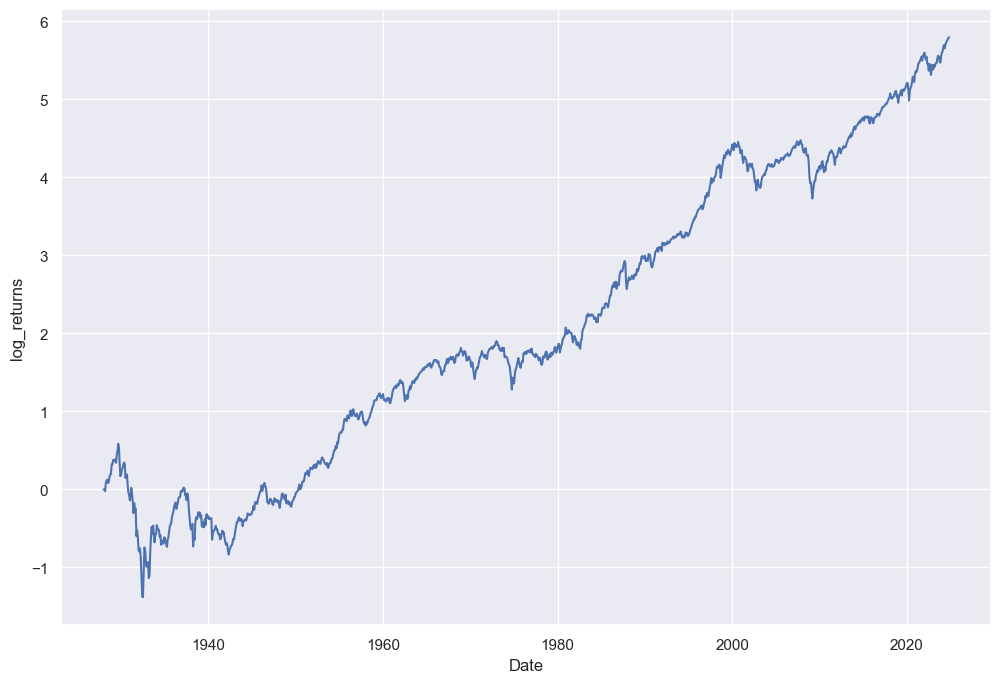

In [568]:
sns.lineplot(M_Cumsum)
# sns.lineplot(M_return)

In [559]:
np.round(M_data["log_returns"].sum(),2)

np.float64(5.8)

The continously compounded return for the last 98 years has been 5.8

# Creating returns calander

getting months

In [560]:
months = [datetime(1,x,1).strftime("%B") for x in range(1,13)]
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

Create pivot table based on year and month

In [561]:
data["Year"] = data.index.year
data["Month"] = data.index.month_name()

heatmap_data = pd.pivot_table(data, values="log_returns", index="Year", columns="Month",aggfunc="sum")

heatmap_data = heatmap_data[months] # Ensuring the order of the months
heatmap_data = heatmap_data.apply(lambda x : np.exp(x) - 1) # Converting to simple returns

plot pivot table to get the return for each month every year

<Axes: xlabel='Year', ylabel='Month'>

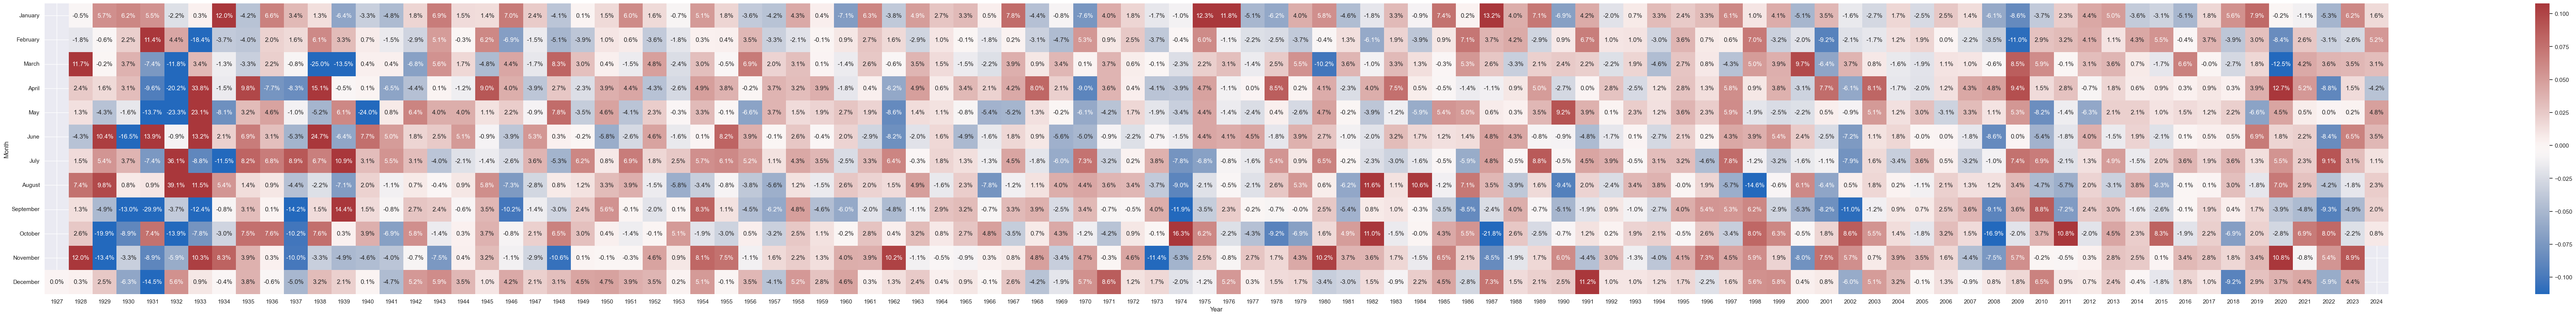

In [562]:
sns.set_theme(rc={'figure.figsize':(100, 10)})
sns.heatmap(heatmap_data.T,annot=True,robust=True,fmt=".1%",cmap="vlag")

Median returns for each month over the last 98 years of the S&P500

In [563]:
month_returns = heatmap_data.median() * 100

month_returns.sort_values(ascending=False)

Month
November     1.627035
July         1.622370
January      1.548531
December     1.488916
March        1.109581
May          1.049138
April        0.942474
October      0.931704
August       0.865458
June         0.299576
February     0.268404
September   -0.486086
dtype: float64

Text(0.5, 1.0, 'Median expected return of a month')

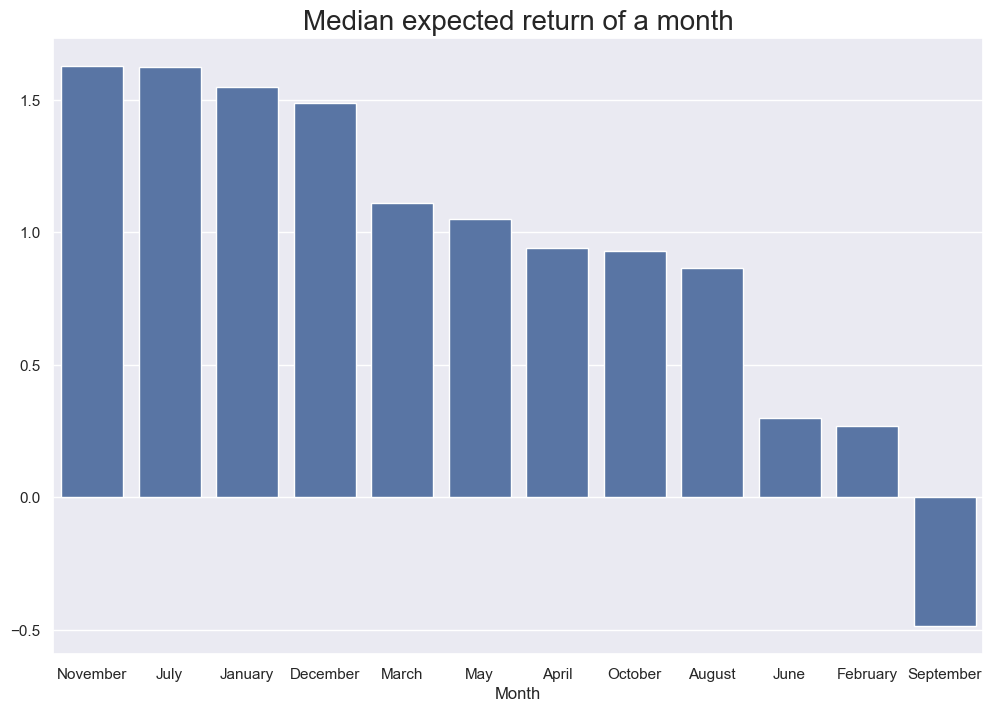

In [564]:
sns.set_theme(rc={'figure.figsize':(12, 8)})
ax = sns.barplot(month_returns, order=month_returns.sort_values(ascending=False).index)
ax.set_title("Median expected return of a month",fontsize=20)

Distribution of returns per month

<Axes: xlabel='Month'>

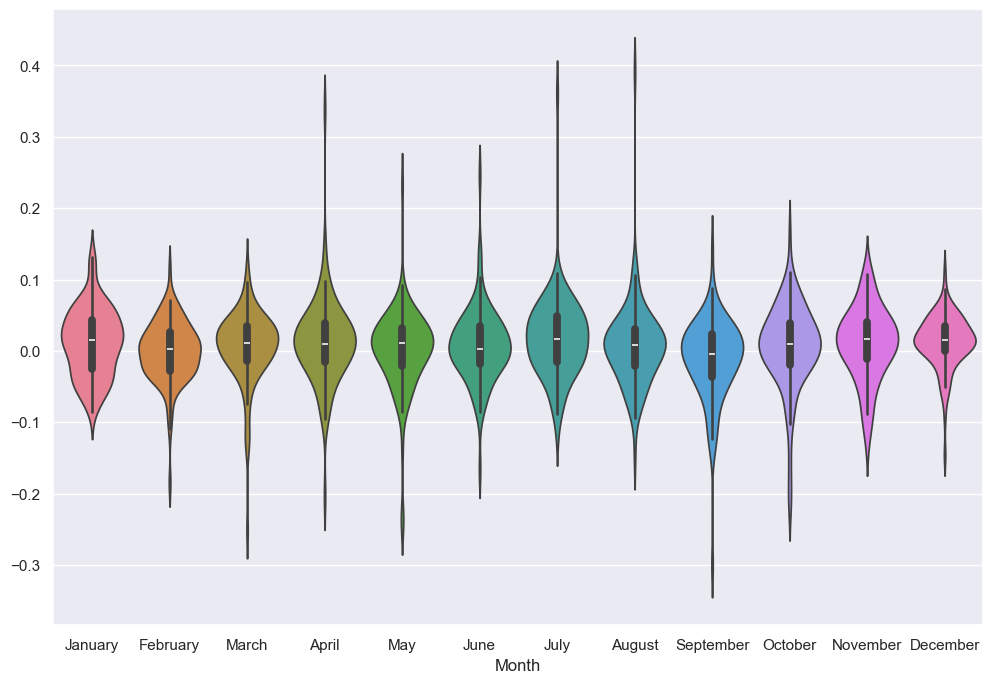

In [570]:
sns.violinplot(heatmap_data)